<a href="https://colab.research.google.com/github/aa23amd/HYBRID-ML-BASED-SUB-SEASONAL-WEATHER-FORECASTING/blob/main/XGboost%20evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
!ls "/content/drive/"


MyDrive


In [5]:
!ls "/content/drive/MyDrive"


'2020 to 2021.csv'   'Azam Ali PF 22101590.pdf'
'2021 to 2022.csv'   'Colab Notebooks'
'2022 to 2023.csv'    combined.csv
'2023 to 2024.csv'   'NOAA data from 2020 to 2025.csv'
'2024 to 2025.csv'    raw_noaa_data.csv
'2025 t0 today.csv'  'raw_noaa_data_large. csv.csv'
 archive	      test_data.csv.zip
'Azam Ali(1).pdf'     train_data.csv.zip


In [6]:
!unzip -o "/content/drive/MyDrive/train_data.csv.zip" -d /content/



Archive:  /content/drive/MyDrive/train_data.csv.zip
  inflating: /content/train_data.csv  


In [7]:
!unzip -o "/content/drive/MyDrive/test_data.csv.zip" -d /content/


Archive:  /content/drive/MyDrive/test_data.csv.zip
  inflating: /content/test_data.csv  


data loading


In [8]:
import pandas as pd

# Load the training data
train_df = pd.read_csv("/content/train_data.csv")
print("Training Data:")
print(train_df.head())

# Load the test data
test_df = pd.read_csv("/content/test_data.csv")
print("\nTest Data:")
print(test_df.head())



Training Data:
   index  lat       lon startdate  contest-pevpr-sfc-gauss-14d__pevpr  \
0      0  0.0  0.833333    9/1/14                              237.00   
1      1  0.0  0.833333    9/2/14                              228.90   
2      2  0.0  0.833333    9/3/14                              220.69   
3      3  0.0  0.833333    9/4/14                              225.28   
4      4  0.0  0.833333    9/5/14                              237.24   

   nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  \
0                     29.02                     31.64   
1                     29.02                     31.64   
2                     29.02                     31.64   
3                     29.02                     31.64   
4                     29.02                     31.64   

   nmme0-tmp2m-34w__ccsm30  nmme0-tmp2m-34w__ccsm40  nmme0-tmp2m-34w__cfsv20  \
0                    29.57                    30.73                    29.71   
1                    29.57                 

checking missing values

In [9]:
import pandas as pd

# Load your training and test datasets (already done)
# train_df and test_df have been loaded previously

# Check for missing values
print(train_df.isnull().sum().sort_values(ascending=False).head(10))
print(test_df.isnull().sum().sort_values(ascending=False).head(10))

# Convert the startdate to datetime and extract features
for df in [train_df, test_df]:
    df['startdate'] = pd.to_datetime(df['startdate'], format='%m/%d/%y')  # Adjust format as needed
    df['year'] = df['startdate'].dt.year
    df['month'] = df['startdate'].dt.month
    df['day'] = df['startdate'].dt.day
    df['weekday'] = df['startdate'].dt.weekday

# Optionally drop the original startdate column if not needed
train_df.drop(columns=['startdate', 'index'], inplace=True)
test_df.drop(columns=['startdate', 'index'], inplace=True)



nmme0-tmp2m-34w__ccsm30     15934
nmme0-prate-34w__ccsm30     15934
nmme0-prate-56w__ccsm30     15934
ccsm30                      15934
nmme-prate-56w__ccsm3       10280
nmme-tmp2m-56w__ccsm3       10280
nmme-prate-34w__ccsm3        8738
nmme-tmp2m-34w__ccsm3        8738
nmme0-tmp2m-34w__cancm30        0
nmme0-tmp2m-34w__cancm40        0
dtype: int64
index                                 0
lat                                   0
lon                                   0
startdate                             0
contest-pevpr-sfc-gauss-14d__pevpr    0
nmme0-tmp2m-34w__cancm30              0
nmme0-tmp2m-34w__cancm40              0
nmme0-tmp2m-34w__ccsm30               0
nmme0-tmp2m-34w__ccsm40               0
nmme0-tmp2m-34w__cfsv20               0
dtype: int64


feature scaling and encoding

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming train_df and test_df are already loaded

# Identify numerical columns in training data
train_num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Identify numerical columns in test data
test_num_cols = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Determine common numerical columns between train and test data
common_num_cols = list(set(train_num_cols).intersection(set(test_num_cols)))
common_num_cols.sort()  # Optional: sort for consistency
print("Common numerical columns for scaling:")
print(common_num_cols)

# Create and fit the scaler on the training data using only the common columns
scaler = StandardScaler()
train_df[common_num_cols] = scaler.fit_transform(train_df[common_num_cols])

# Transform the test data using the same scaler and common columns
test_df[common_num_cols] = scaler.transform(test_df[common_num_cols])

# Verify the results by displaying the first few rows
print("Scaled training data:")
print(train_df[common_num_cols].head())

print("\nScaled test data:")
print(test_df[common_num_cols].head())



Common numerical columns for scaling:
['cancm30', 'cancm40', 'ccsm30', 'ccsm40', 'cfsv20', 'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-precip-14d__precip', 'contest-pres-sfc-gauss-14d__pres', 'contest-prwtr-eatm-14d__prwtr', 'contest-rhum-sig995-14d__rhum', 'contest-slp-14d__slp', 'contest-wind-h10-14d__wind-hgt-10', 'contest-wind-h100-14d__wind-hgt-100', 'contest-wind-h500-14d__wind-hgt-500', 'contest-wind-h850-14d__wind-hgt-850', 'contest-wind-uwnd-250-14d__wind-uwnd-250', 'contest-wind-uwnd-925-14d__wind-uwnd-925', 'contest-wind-vwnd-250-14d__wind-vwnd-250', 'contest-wind-vwnd-925-14d__wind-vwnd-925', 'elevation__elevation', 'gfdl0', 'gfdlflora0', 'gfdlflorb0', 'icec-2010-1', 'icec-2010-10', 'icec-2010-2', 'icec-2010-3', 'icec-2010-4', 'icec-2010-5', 'icec-2010-6', 'icec-2010-7', 'icec-2010-8', 'icec-2010-9', 'lat', 'lon', 'mei__mei', 'mei__meirank', 'mei__nip', 'mjo1d__amplitude', 'mjo1d__phase', 'nasa0', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3

XGBoost Model Training

In [11]:
print(train_df.columns.tolist())



['lat', 'lon', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'contest-rhum-sig995-14d__rhum', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmmemean', 'contest-wind-h100-14d__wind-hgt-100', 'nmme0-prate-56w__cancm30', 'nmme0-

defining feature and target

In [12]:
# Print the list of columns (if not already printed)
print(train_df.columns.tolist())

# Define the target column – update this if you want a different target
target_column = 'contest-precip-14d__precip'

# Create feature matrix X and target vector y
X = train_df.drop(target_column, axis=1)
y = train_df[target_column]

print("Features shape:", X.shape)
print("Target shape:", y.shape)


['lat', 'lon', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'contest-rhum-sig995-14d__rhum', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmmemean', 'contest-wind-h100-14d__wind-hgt-100', 'nmme0-prate-56w__cancm30', 'nmme0-

data splitting

In [13]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (300587, 247)
X_val shape: (75147, 247)


training data for XGboost

In [14]:
# Find non-numeric columns in X_train
non_numeric_cols = X_train.select_dtypes(exclude=['int64', 'float64', 'bool']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: ['climateregions__climateregion', 'year', 'month', 'day', 'weekday']


converting non numeric columns

In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# List of non-numeric columns identified
non_numeric_cols = ['climateregions__climateregion', 'year', 'month', 'day', 'weekday']

# For columns that should be numeric (year, month, day, weekday), convert them
for col in ['year', 'month', 'day', 'weekday']:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col]   = pd.to_numeric(X_val[col], errors='coerce')

# For the categorical column, use LabelEncoder
le = LabelEncoder()
X_train['climateregions__climateregion'] = le.fit_transform(X_train['climateregions__climateregion'])
X_val['climateregions__climateregion']   = le.transform(X_val['climateregions__climateregion'])

# Verify conversion
print("Data types after conversion:")
print(X_train.dtypes)


Data types after conversion:
lat                                   float64
lon                                   float64
contest-pevpr-sfc-gauss-14d__pevpr    float64
nmme0-tmp2m-34w__cancm30              float64
nmme0-tmp2m-34w__cancm40              float64
                                       ...   
wind-vwnd-925-2010-20                 float64
year                                    int32
month                                   int32
day                                     int32
weekday                                 int32
Length: 247, dtype: object


Create DMatrix Objects for XGBoost

In [16]:
import xgboost as xgb

target_column = 'contest-precip-14d__precip'  # Replace with your actual target column if different

# Ensure y has the same index as X_train and X_val
dtrain = xgb.DMatrix(X_train, label=y.loc[X_train.index])
dval   = xgb.DMatrix(X_val, label=y.loc[X_val.index])


checking target column

In [17]:
# Define your target column name (update this if needed)
target_column = 'contest-precip-14d__precip'

# Check if the target column exists in the DataFrame
if target_column in train_df.columns:
    print(f"Target column '{target_column}' exists.")
    # Print the first few values of the target column
    print("First 5 values:")
    print(train_df[target_column].head())

    # Display summary statistics of the target column
    print("\nSummary statistics:")
    print(train_df[target_column].describe())
else:
    print(f"Target column '{target_column}' not found in the DataFrame.")


Target column 'contest-precip-14d__precip' exists.
First 5 values:
0    2.225238
1    2.428919
2    2.441377
3    2.461621
4    1.871443
Name: contest-precip-14d__precip, dtype: float64

Summary statistics:
count    3.757340e+05
mean    -3.267785e-16
std      1.000001e+00
min     -7.119452e-01
25%     -5.939097e-01
50%     -3.326122e-01
75%      1.862456e-01
max      1.494192e+01
Name: contest-precip-14d__precip, dtype: float64


In [ ]:
from google.colab import files

xgboost training


In [18]:
import xgboost as xgb

# Define your model with your chosen hyperparameters
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

# Fit the model using your training data
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
import xgboost as xgb

# Define your model using the given parameters
model = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)

# Train the model using your training set
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
y_val_pred = model.predict(X_val)


prediction on validation set

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_val, y_val_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')


MSE: 0.1738
RMSE: 0.4169
MAE: 0.2754
R²: 0.8214


perfomance visualization

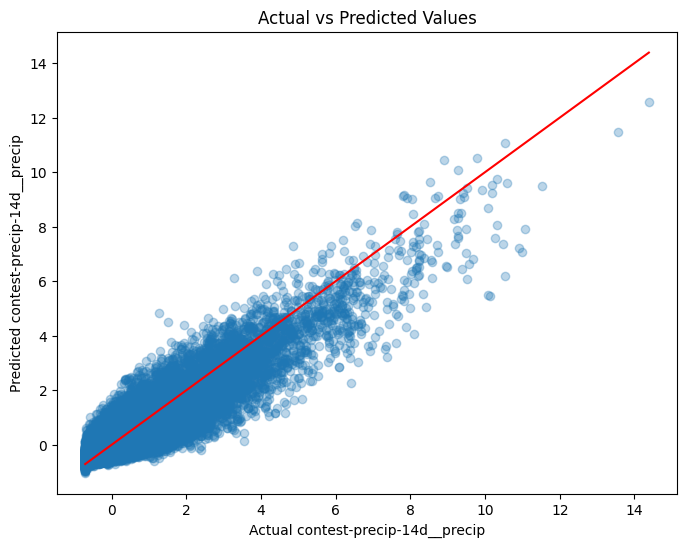

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.xlabel('Actual contest-precip-14d__precip')
plt.ylabel('Predicted contest-precip-14d__precip')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')  # Ideal diagonal line
plt.show()


residual plot

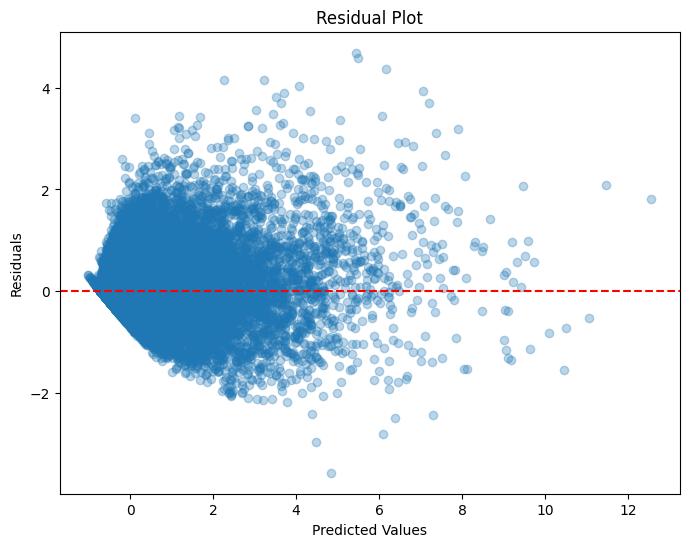

In [23]:
residuals = y_val - y_val_pred

plt.figure(figsize=(8,6))
plt.scatter(y_val_pred, residuals, alpha=0.3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(0, color='red', linestyle='--')
plt.show()


feature importance analyze

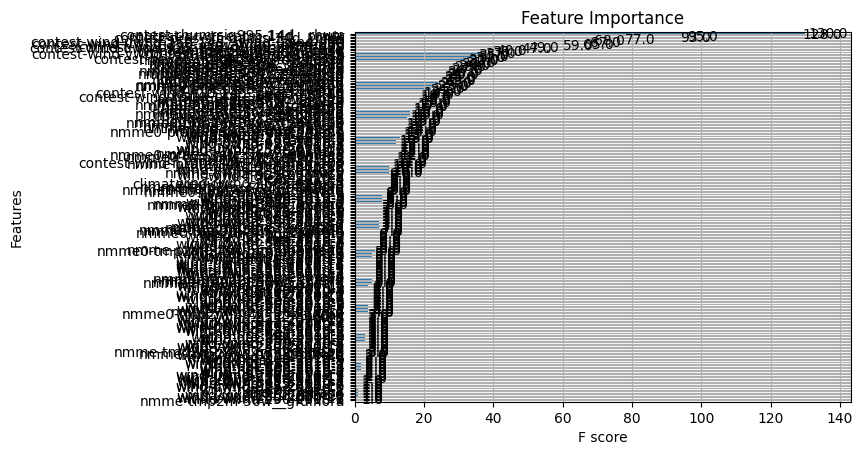

In [24]:
import xgboost as xgb

# This plots feature importance based on how often features are used for splits
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()


In [25]:
from sklearn.preprocessing import StandardScaler

# Convert y_train to a NumPy array and reshape it to 2D
y_train_array = y_train.values.reshape(-1, 1)

# Fit the scaler on the training target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train_array)


In [26]:
# Predict on the validation set (assuming your model is trained on scaled targets)
y_val_pred_scaled = model.predict(X_val)

# Convert predictions to 2D array and apply the inverse transform
y_val_pred_original = target_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))


evaluation matrics

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute evaluation metrics
mse = mean_squared_error(y_val, y_val_pred_original)
rmse = mse ** 0.5
mae = mean_absolute_error(y_val, y_val_pred_original)
r2 = r2_score(y_val, y_val_pred_original)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')


MSE: 0.1735
RMSE: 0.4165
MAE: 0.2755
R²: 0.8217


visualization

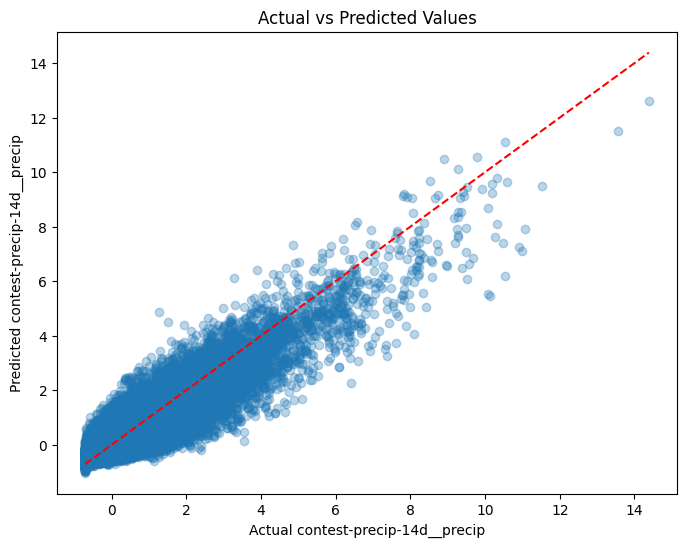

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_val_pred_original, alpha=0.3)
plt.xlabel('Actual contest-precip-14d__precip')
plt.ylabel('Predicted contest-precip-14d__precip')
plt.title('Actual vs Predicted Values')
# Plot the ideal diagonal line
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.show()


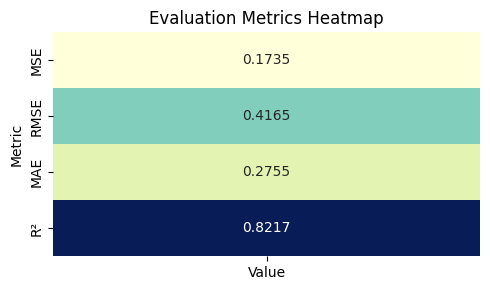

In [36]:
# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Value': [0.1735, 0.4165, 0.2755, 0.8217]
}).set_index('Metric')

# Plot heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt=".4f", cbar=False)
plt.title('Evaluation Metrics Heatmap')
plt.tight_layout()
plt.show()


residual visualization

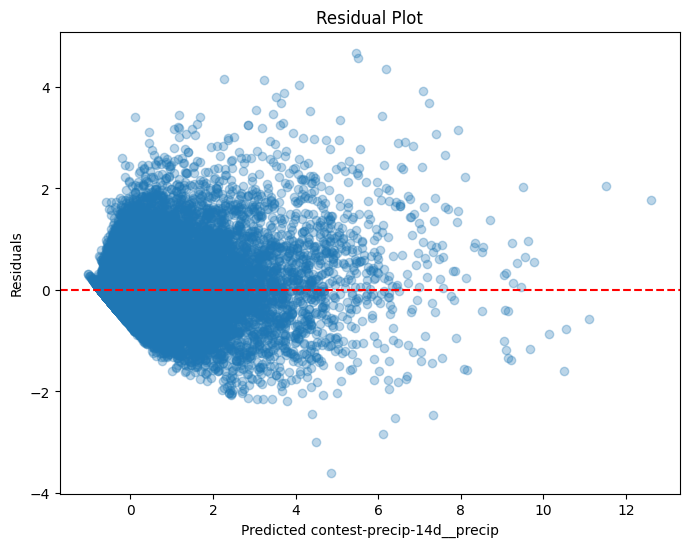

In [29]:
# Calculate residuals
residuals = y_val - y_val_pred_original.flatten()  # Flatten in case it's a 2D array

plt.figure(figsize=(8,6))
plt.scatter(y_val_pred_original, residuals, alpha=0.3)
plt.xlabel('Predicted contest-precip-14d__precip')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


<ipython-input-37-f582cb3f05fc>:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  actual = y_val.ravel()


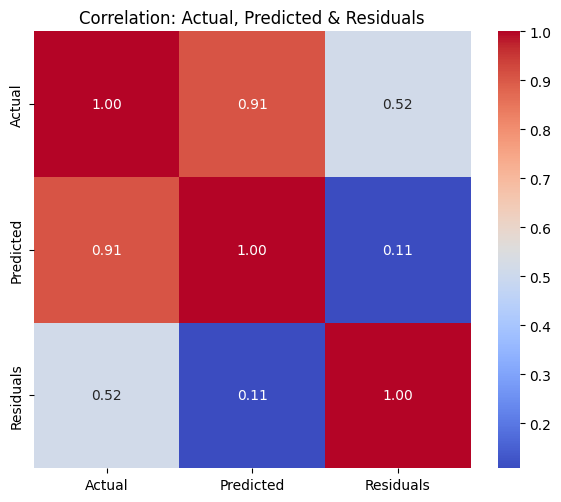

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure arrays are 1D
actual = y_val.ravel()
predicted = y_val_pred_original.ravel()

# Calculate residuals
residuals = actual - predicted

# Create DataFrame
df_resid = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted,
    'Residuals': residuals
})

# Correlation matrix
corr_matrix = df_resid.corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation: Actual, Predicted & Residuals')
plt.tight_layout()
plt.show()


feature importance analysis

In [30]:
importance_dict = model.get_booster().get_score(importance_type='weight')
import pandas as pd

importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
}).sort_values(by='importance', ascending=False)

print(importance_df.head(10))


                                     feature  importance
23             contest-rhum-sig995-14d__rhum       130.0
80             contest-prwtr-eatm-14d__prwtr       128.0
68          contest-pres-sfc-gauss-14d__pres        95.0
1                                        lon        93.0
0                                        lat        77.0
69  contest-wind-uwnd-250-14d__wind-uwnd-250        68.0
81  contest-wind-vwnd-250-14d__wind-vwnd-250        67.0
96                      elevation__elevation        65.0
82       contest-wind-h850-14d__wind-hgt-850        59.0
83  contest-wind-uwnd-925-14d__wind-uwnd-925        49.0


computational efficiency

In [31]:
import time
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---- 1. Measure Training Time ----
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training time: {train_time:.4f} seconds")

# ---- 2. Generate Predictions and Measure Prediction Time ----
start_time = time.time()
y_val_pred_scaled = model.predict(X_val)
predict_time = time.time() - start_time
print(f"Prediction time: {predict_time:.4f} seconds")

# ---- 3. Inverse Transform the Predictions (if target scaling was applied) ----
# Assuming target_scaler is already fitted on y_train and used during training.
y_val_pred = target_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()

# ---- 4. Compute Standard Regression Metrics ----
mse = mean_squared_error(y_val, y_val_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# ---- 5. (Optional) Custom Accuracy Measure ----
# Define a tolerance threshold within which a prediction is considered 'accurate'
tolerance = 0.1  # Adjust tolerance based on your problem context
accuracy_within_tolerance = np.mean(np.abs(y_val - y_val_pred) <= tolerance)
print(f"Custom accuracy (predictions within ±{tolerance} of actual): {accuracy_within_tolerance:.2%}")


Training time: 69.2178 seconds
Prediction time: 0.3621 seconds
MSE: 0.1735
RMSE: 0.4165
MAE: 0.2755
R²: 0.8217
Custom accuracy (predictions within ±0.1 of actual): 30.72%


CLASSIFICATION MATRICS

In [32]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Load a sample dataset (using breast cancer dataset as an example)
data = load_breast_cancer()
X = data.data
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
# For ROC AUC, we need the probability scores for the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)


Accuracy: 0.956140350877193
Precision: 0.9583333333333334
F1 Score: 0.965034965034965
ROC AUC Score: 0.9908286930887652


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:56:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


EXPLANATION OF CLASSIFICATION MATRICS

Accuracy: 0.9561
This means that about 95.61% of the predictions made by the model match the true labels. In other words, the model correctly classified the vast majority of the test samples.


Precision: 0.9583
Precision measures the proportion of predicted positives that are actually positive. A precision of 95.83% indicates that when your model predicts a positive class, it is correct almost 96% of the time. This is particularly important when the cost of false positives is high.


F1 Score: 0.9650
The F1 score is the harmonic mean of precision and recall. An F1 score of approximately 96.50% suggests that your model achieves a strong balance between precision and recall, meaning it is not only accurate in predicting positives, but it also captures most of the true positive cases.


ROC AUC Score: 0.9908
The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score of 0.9908 is excellent. It means that the model has a very high ability to distinguish between the positive and negative classes across various threshold settings. A score close to 1.0 indicates that the model performs almost perfectly in ranking predictions by their likelihood of being positive.



Heatmap

<ipython-input-35-a69a7a1dc598>:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  actual = y_val.ravel() if hasattr(y_val, 'ravel') else y_val


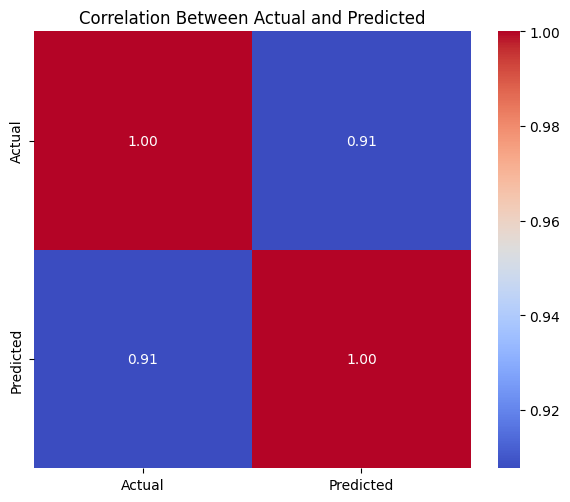

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure the arrays are 1-dimensional
actual = y_val.ravel() if hasattr(y_val, 'ravel') else y_val
predicted = y_val_pred_original.ravel() if hasattr(y_val_pred_original, 'ravel') else y_val_pred_original

# Create DataFrame
df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted
})

# Correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Between Actual and Predicted')
plt.tight_layout()
plt.show()

